### 0. 파이썬 모듈 가져오기

모듈(module)은 각종 변수, 함수, 클래스를 담고 있는 파일이고, 패키지(package)는 여러 모듈을 묶은 것입니다.

> - numpy : NumPy는 행렬이나 일반적으로 대규모 다차원 배열을 쉽게 처리 할 수 있도록 지원하는 파이썬의 라이브러리입니다.
> - pandas : Pandas는 데이터 조작 및 분석을 위한 Python 프로그래밍 언어 용으로 작성된 소프트웨어 라이브러리입니다.
> - matplotlib : Matplotlib는 Python 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리입니다.
> - seaborn : matplotlib 기반으로 만들어졌으며, 데이터 시각화 기능을 가지고 있습니다.
> - cv2 : OpenCV는 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리입니다.
> - torch : PyTorch는 Python을 위한 오픈소스 머신 러닝 라이브러리입니다.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import seaborn as sns

from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer

> 분류할 라벨은 총 5가지 입니다.

In [4]:
classes = ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']

### 1. 데이터 비율 확인 체크

> 경로의 마지막 부분이 라벨이므로, 마지막을 인덱싱하기 위해 -1 합니다.

In [11]:
# 데이터 비율 확인 체크
def data_check(path=".\\dataset\\YogaPoses"):
    count_dit = {}
    for root, dirs, files in os.walk(path):
        # print(root)
        # print(root.split('\\')[-1])
        if files != [] and str(root.split("\\")[-1]) in classes:
            count_dit[str(root.split('\\')[-1])] = len(files)
    return count_dit

> 각 라벨에 대한 데이터가 몇 개 있는지 그래프로 확인해봅니다.

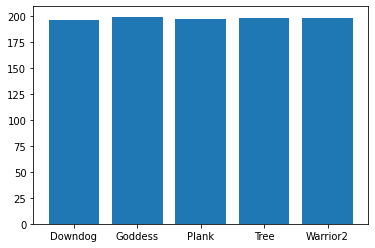

In [12]:
counts = data_check()
plt.bar(list(counts.keys()), list(counts.values()))
plt.show()

### 2. 훈련 및 검증 데이터셋으로 분할하기

> 매개변수로 받은 split_predictions 비율 만큼 훈련 및 검증 데이터셋으로 랜덤하게 분할됩니다.<br>
> 파이썬의 집합 자료형으로 변환하여, 차집합을 이용하여 구현합니다.

In [16]:
# 데이터 train val
def data_split(path=".\\dataset\\YogaPoses", split_predictions=0.1):
    train_dict = {}
    val_dict = {}
    counts = data_check(path)
    for root, dirs, files in os.walk(path):
        if files != [] and str(root.split('\\')[-1]) in classes:
            file_paths = [os.path.join(root, files[i])
                          for i in range(len(files))]

            valid_index = np.random.randint(low=0, high=len(files), size=int(len(files)*split_predictions))
            train_index = list(set(range(0, len(files))) - set(valid_index))

            train_dict[str(root.split('\\')[-1])] = [file_paths[idx]
                                                     for idx in train_index]
            val_dict[str(root.split('\\')[-1])] = [file_paths[idx]
                                                   for idx in valid_index]

    return train_dict, val_dict

In [17]:
train_split_data, val_split_data = data_split()
print("Train data size : ", [len(l) for l in train_split_data.values()])
print("Val data size : ", [len(l) for l in val_split_data.values()])

Train data size :  [177, 180, 179, 180, 180]
Val data size :  [19, 19, 19, 19, 19]


### 3. Custom dataset

torch.utils.data.Dataset을 상속받아 \__init__(), \__getitem__(), \__len__()을 구현합니다.

> - \__init__() : 생성자입니다. 인스턴스 생성시 받은 매개변수를 인스턴스 변수에 저장합니다.
> - \__getitem__() : 생성자에서 받은 데이터셋은 5가지 라벨 인덱스에 접근 후, 각 인덱스로 접근해야합니다. 이러한 인덱스 접근이 아닌<br>
0-195는 Downdog, 196-394는 Goddess, 395-592는 Plank ... 이런식으로 일렬로 접근 가능하도록 고쳐야합니다. 따라서 누적합을 사용합니다.
> - \__len__() : 각 5가지 라벨의 총 데이터 개수를 합산하여 반환합니다.

In [18]:
# 3. custom dataset
class YogaPosesData(Dataset):

    # chess Piece dataset class

    def __init__(self, data_dict, transform=None):
        # Args : data_dict (dict)
        self.data_dict = data_dict
        self.transform = transform

    def __getitem__(self, idx):
        counts = [len(l) for l in self.data_dict.values()]
        # cumsum은 배열에서 주어진 축에 따라 누적되는 원소들의 누적 합을 계산하는 함수
        sum_counts = list(np.cumsum(counts))
        # 0, Downdog의 데이터 수(196), Goddess의 데이터 수(196 + 199), ... ,Infinitie (무한)
        sum_counts = [0] + sum_counts + [np.inf]

        for c, v in enumerate(sum_counts):
            if idx < v:
                i = (idx - sum_counts[c-1]) - 1
                break

        label = list(self.data_dict.keys())[c-1]
        img = Image.open(self.data_dict[str(label)][i]).convert("RGB")

        # data augmentation
        if self.transform:
            img = self.transform(img)

        return img, classes.index(str(label))

    def __len__(self):
        return sum([len(l) for l in self.data_dict.values()])

### 4. Data augmentation

> 원본 이미지에 적절한 변형을 가해서 새로운 데이터를 만들어 냅니다.

In [28]:
# 4. data augmentation
train_data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor()
])
val_data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(),
    transforms.ToTensor()
])

### 5. Data loader
데이터 로더 특징
> - 여러 파일로 쪼개져서 저장/읽기 가능
> - 간단한 Key Value 구조
> - Lazy data loading(메모리 보호)
> - IO 병목을 막기 위한 데이터 캐시
> - 데이터 custom transform을 유연하게 적용하는 기능

In [32]:
# Custom dataset의 인스턴스 만들기
data_train = YogaPosesData(train_split_data, transform=train_data_transform)
data_val = YogaPosesData(val_split_data, transform=val_data_transform)
# Data loader의 인스턴스 만들기
train_loader = DataLoader(data_train, batch_size=10, shuffle=True)
val_loader = DataLoader(data_val, batch_size=10, shuffle=False)

### 6. 훈련 데이터, 검증 데이터 Check

Total number a train images >>  896
Val number a val images >>  95


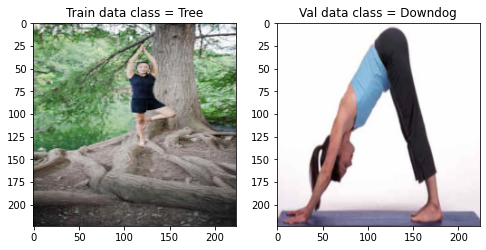

In [35]:
# 6. train data val data check
t_idx = np.random.randint(0, len(data_train))
v_idx = np.random.randint(0, len(data_val))

print("Total number a train images >> ", len(data_train))
print("Val number a val images >> ", len(data_val))

t_img, t_label = data_train[t_idx]
v_img, v_label = data_val[v_idx]

# show train image check
plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.imshow(t_img.numpy().transpose(1, 2, 0))
plt.title(f'Train data class = {classes[t_label]}')
plt.subplot(122)
plt.imshow(v_img.numpy().transpose(1, 2, 0))
plt.title(f'Val data class = {classes[v_label]}')
plt.show()

### 7. Loss Function

In [37]:
# Loss Function
criterion = nn.CrossEntropyLoss()

### 8. 모델 선택

> Pretrained: ImageNet 등 데이터셋에 대해 사전 학습된 모델의 가중치(weight)

In [38]:
# device
# Windows, Linux 사용자
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Mac M1
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')
print("device info >> ", device)

device info >>  cpu


> (6): Linear(in_features=4096, out_features=1000, bias=True)<br>
총 5가지 라벨이므로, 마지막 6번째 Linear의 out_feautres가 5가 되도록 변경합니다.

In [42]:
# model chose
def base_model_build(device):

    # Load the pretrained model from pytorch
    vgg11 = models.vgg11(pretrained=True)
    # print(vgg11)
    for param in vgg11.features.parameters():
        param.requires_grad = False

    # (6): Linear(in_features=4096, out_features=1000, bias=True)
    # 총 5가지 라벨이므로, 마지막 6번째 Linear의 out_feautres가 5가 되는 Linear 인스턴스를 만듭니다.
    n_inputs = vgg11.classifier[6].in_features
    last_layer = nn.Linear(n_inputs, len(classes))

    # 마지막 6번째 classifier를 위에서 만들어진 인스턴스를 참조하도록 합니다.
    vgg11.classifier[6] = last_layer
    # print(vgg11)
    if device:
        print('training ...')
        vgg11.to(device)

    return vgg11

base_model_build(device)

training ...


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### 9. loss 및 accuracy 시각화

In [45]:
def loss_acc_visualize(history, optim, path):
    plt.figure(figsize=(20, 10))

    plt.suptitle(str(optim))

    plt.subplot(121)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title("loss Curves")

    plt.subplot(122)
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.legend()
    plt.title("ACC Curves")

    plt.savefig(str(path) + 'loss_acc.png')

### 10. gradient 시각화

> loss를 줄이기 위해, Optimizer에 따라 가중치, 편향을 어떻게 찾아가는지 시각화

In [46]:
def grad_visualize(history, optim, path, ylimit=10):

    # gradient norm distribution

    plt.figure(figsize=(20, 10))
    plt.suptitle(str(optim))
    plt.subplot(131)
    sns.kdeplot(weight_grads1, shade=True)
    sns.kdeplot(bias_grads1, shade=True)
    plt.legend(['weight', 'bias'])
    plt.title("Linear layer 1")
    plt.ylim(0, ylimit)

    plt.subplot(132)
    sns.kdeplot(weight_grads2, shade=True)
    sns.kdeplot(bias_grads2, shade=True)
    plt.legend(['weight', 'bias'])
    plt.title("Linear layer 2")
    plt.ylim(0, ylimit)

    plt.subplot(133)
    sns.kdeplot(weight_grads3, shade=True)
    sns.kdeplot(bias_grads3, shade=True)
    plt.legend(['weight', 'bias'])
    plt.title("Linear layer 3")
    plt.ylim(0, ylimit)

    plt.savefig(str(path) + "grad_norms.png")

### 11.  모델 예측 시각화
> - torch.no_grad() : autograd engine을 비활성화 시켜 필요한 메모리를 줄여주고 연산속도를 증가시크는 역할을 합니다.
> - torch.eval() : Dropout, Batchnorm 등의 기능을 비활성화시켜 추론 모드로 조정해 주는 역할을 합니다.

In [49]:
def visual_predict(model, data=data_val):
    # 검증용 데이터 중에 하나 랜덤하게 선택
    c = np.random.randint(0, len(data))
    img, label = data[c]

    with torch.no_grad():
        model.eval()
        out = model(img.view(1, 3, 224, 224).to(device))
        out = torch.exp(out)
        print(out)

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.title(str(classes[label]))
    plt.subplot(122)
    plt.barh(classes, out.cpu().numpy()[0])

    plt.show()

### 12.  각 라벨별 Accuracy를 반환

In [48]:
def class_accuracies(model, data_dict=val_split_data, classes=classes):
    accuracy_dic = {}
    with torch.no_grad():
        model.eval()

        for c in data_dict.keys():
            correct_count = 0
            total_count = len(data_dict[str(c)])
            gt = classes.index(str(c))

            for path in data_dict[str(c)]:
                im = Image.open(path).convert('RGB')

                im = transforms.ToTensor()(im)
                im = transforms.Resize((224, 224))(im)
                out = model(im.view(1, 3, 224, 244)).to(device)
                out = torch.exp(out)
                pred = list(out.cpu.numpy()[0])
                pred = pred.index(max(pred))

                if gt == pred:
                    correct_count += 1

            print(f"Acc for class {str(c)} : ", correct_count / total_count)
            accuracy_dic[str(c)] = correct_count / total_count

    return accuracy_dic